**Introduction**

The Histopathologic Cancer Detection project is a binary image classification task where the goal is to identify metastatic cancer in small image patches taken from larger digital pathology scans. 
Metastatic cancer is cancer that has spread from the primary site to other parts of the body. 
The challenge is to develop a model that can accurately classify whether an image patch contains metastatic tissue (positive) or not (negative).

**Data description**

Each image is 96x96 pixels, stored in the RGB color format.

**Dataset structure**

Training set: contains labeled images, where each image has a corresponding label indicating whether it contains cancerous tissue (1) or not (0).

Test set: contains unlabeled images, where the task is to predict the labels.

Label distribution: the labels are binary (0 or 1), with a clear class imbalance, there are significantly more images without cancerous tissue than with.

Images are provided in .tif format.

**Importing libraries**

In [19]:
import matplotlib.pyplot as plt
import pandas as pd 
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score

**Exploratory Data Analysis**

In [2]:
train_labels = pd.read_csv(r"C:/Users/anne-/OneDrive/Documents/Colorado Boulder/Introduction to Deep Learning/Week3 Histopathologic Cancer Detection/train_labels.csv")
train_images_path = r"C:\Users\anne-\OneDrive\Documents\Colorado Boulder\Introduction to Deep Learning\Week3 Histopathologic Cancer Detection\Extracted files\train"
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


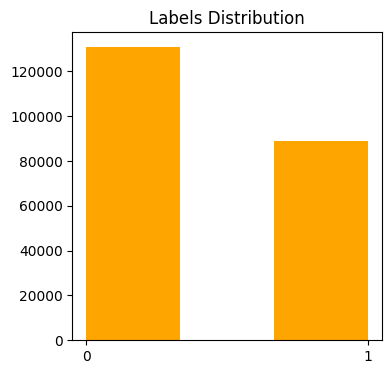

In [3]:
plt.figure(figsize=(4,4))
plt.hist(train_labels["label"], bins = 3, color = "orange")
plt.title("Labels Distribution")
plt.xticks([0,1])
plt.show()

There is a significant class imbalance with a lot less images without cancerous than with. 

Let's visualize a sample of images.

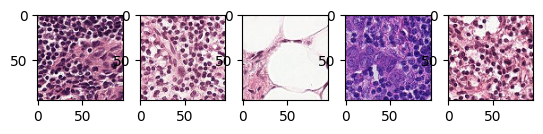

In [4]:
all_images = os.listdir(train_images_path)
def view_images(k) :
    sampled_images = random.sample(all_images, k)
    for idx, image in enumerate(sampled_images) :
        image_path = os.path.join(train_images_path, image)
        sample_image_view = Image.open(image_path)
        plt.subplot(1,k,idx+1)
        plt.imshow(sample_image_view) 
    plt.show()
view_images(5)

**Data Preprocessing**

In [5]:
train_labels["label"] = train_labels["label"].astype(str)
train_labels["id"] = train_labels["id"].apply(lambda x : x + ".tif")

datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 30, 
    width_shift_range = 0.3, 
    height_shift_range= 0.3, 
    shear_range = 0.3, 
    zoom_range = 0.3, 
    horizontal_flip = True, 
    validation_split = 0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe = train_labels, 
    directory = train_images_path, 
    x_col = "id", 
    y_col = "label", 
    subset = "training", 
    batch_size = 64, 
    seed = 42, 
    shuffle = True, 
    class_mode = "binary", 
    target_size = (64,64)
)

val_gen = datagen.flow_from_dataframe(
    dataframe = train_labels, 
    directory = train_images_path, 
    x_col = "id", 
    y_col = "label", 
    subset = "validation", 
    batch_size = 64, 
    seed = 42, 
    shuffle = True, 
    class_mode = "binary", 
    target_size = (64,64)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


**Data augmentation**

I processed several augmentation techniques : rescaling, rotation, shifting, shearing, zooming and flipping to prepare the images for the model.

Images are resized to 64x64 pixels.

**Model Architecture**

I am choosing a CNN model with the Sequential API. 

I will include the following :

Two convolutional layers with adjustable filter sizes.

Max pooling layers for down-sampling.

A fully connected dense layer with a customizable number of units.

A dropout layer to prevent overfitting.

A final output layer with a sigmoid activation function for binary classification.

The model will be compiled with the Adam optimizer and binary cross-entropy loss.

**Hyperparameter Tuning**

The model's hyperparameters, filter sizes, dense units, dropout rate and learning rate will be tuned using Keras Tuner.

I will use a Bayesian optimization strategy to maximize validation AUC across 8 trials.

In [6]:
def build_model(hp) :
    model = Sequential()
    
    model.add(Conv2D(
        filters = hp.Int("conv_1_filter", min_value = 16, max_value = 64, step = 16), 
        kernel_size = (3,3), 
        activation = "relu", 
        input_shape = (64,64,3)
    ))
    
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters = hp.Int("conv_2_filter", min_value = 32, max_value = 128, step = 32), 
        kernel_size = (3,3), 
        activation = "relu"
    ))
    
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(
        units = hp.Int("dense_units", min_value = 64, max_value = 256, step = 64), 
        activation = "relu"
    ))
    
    model.add(Dropout(
        rate = hp.Float("dropout", min_value = 0.2, max_value = 0.5, step = 0.1)
    ))
        
    model.add(Dense(1, activation = "sigmoid")) 

    model.compile(
        optimizer = Adam(
            learning_rate = hp.Float("learning_rate", min_value = 1e-6, max_value = 1e-2, sampling = "LOG")
        ), 
        loss = "binary_crossentropy", 
        metrics = [AUC(name = "auc")]
    )
    
    return model
    
tuner = kt.BayesianOptimization(
    build_model, 
    objective = kt.Objective("val_auc", direction = "max"), 
    max_trials = 8, 
    directory = "tuner_dir", 
    project_name = "Cancer_Detection_Optimization_v15"
)

Reloading Tuner from tuner_dir\Cancer_Detection_Optimization_v15\tuner0.json


In [7]:
tuner.search_space_summary()

early_stop = EarlyStopping(
    monitor = "val_auc", 
    patience = 3, 
    verbose = 1, 
    mode = "min", 
    restore_best_weights = True
)

tuner.search(
    train_gen, 
    validation_data = val_gen,
    epochs = 8, 
    callbacks = [early_stop]
)
    
best_model = tuner.get_best_models(num_models = 1)[0]

val_loss, val_auc = best_model.evaluate(val_gen)

best_model.save("Cancer_Detection_Bayesian_v15.keras" )
print(f"Validation AUC of the best model: {val_auc:.4f}")

Trial 8 Complete [01h 42m 12s]
val_auc: 0.8806902766227722

Best val_auc So Far: 0.9119361042976379
Total elapsed time: 14h 53m 50s


c:\Users\anne-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - auc: 0.9116 - loss: 0.3693
Validation AUC of the best model: 0.9120


**Selected model and performance evaluation**

This is the 15th version for the classification task. 

I started with a simple CNN model without hyperparameter tuning and using accuracy as a metric, I got a reasonably good validation accuracy of 0.84(see curves below). 

We can see that the model was close to convergence from the very first versions. 

For this 15th version, the best model from the tuning process provides an AUC of 0.9116 on the train set and 0.9120 on the validation set. 

This suggests our best model performs very well with train/validation images, but performance decreases with test unseen images. 

I will take time later to focus on that because early_stopping should have helped prevent over-fitting. 

Also, there may be an explanation related to test images themselves.

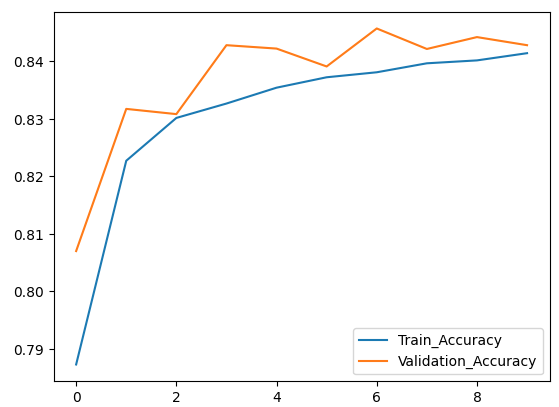

**Testing the model with Test Images**

Let's visualize a few images from the test set.

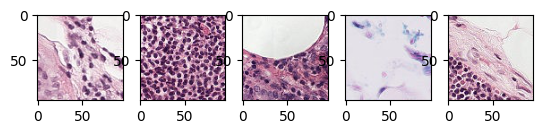

In [8]:
test_images_path = r"C:\Users\anne-\OneDrive\Documents\Colorado Boulder\Introduction to Deep Learning\Week3 Histopathologic Cancer Detection\Extracted files\test"

all_images = os.listdir(test_images_path)
def view_images(k) :
    sampled_images = random.sample(all_images, k)
    for idx, image in enumerate(sampled_images) :
        image_path = os.path.join(test_images_path, image)
        sample_image_view = Image.open(image_path)
        plt.subplot(1,k,idx+1)
        plt.imshow(sample_image_view) 
    plt.show()
view_images(5)

In [9]:
test_ids = [f for f in os.listdir(test_images_path) if f.endswith(".tif")]     

In [10]:
for img_id in test_ids:
    try:
        img_path = os.path.join(test_images_path, img_id)
        img = Image.open(img_path)
        img.verify() 
    except Exception as e:
        print(f"Error with image {img_id}: {e}")
        test_ids.remove(img_id)

Error with image b79a35ace65b3aa7551f426050d7de5dac222dc7.tif: cannot identify image file 'C:\\Users\\anne-\\OneDrive\\Documents\\Colorado Boulder\\Introduction to Deep Learning\\Week3 Histopathologic Cancer Detection\\Extracted files\\test\\b79a35ace65b3aa7551f426050d7de5dac222dc7.tif'


Image b79a35ace65b3aa7551f426050d7de5dac222dc7.tif is not a valid one. 

So, I will manually label it with 0 when I submit the test labels.

In [11]:
test_id_df = pd.DataFrame(test_ids, columns = ["id"])
print(len(test_id_df))
print(len(os.listdir(test_images_path)))

57457
57458


In [12]:
images_test_gen = ImageDataGenerator(rescale = 1./255)
test_gen = images_test_gen.flow_from_dataframe(dataframe = test_id_df, directory = test_images_path, target_size = (64,64), x_col = "id", y_col = None, batch_size = 1, class_mode = None, shuffle = False)

Found 57457 validated image filenames.


In [13]:
from tensorflow.keras.models import load_model
loaded_model = load_model("Cancer_Detection_Bayesian_v15.keras" )

c:\Users\anne-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
predictions = loaded_model.predict(test_gen, steps = len(test_gen), verbose = 1)

57457/57457 ━━━━━━━━━━━━━━━━━━━━ 272s 5ms/step


In [15]:
print(predictions)
len(predictions)

[[0.23421976]
 [0.3100455 ]
 [0.10658032]
 ...
 [0.00105052]
 [0.31245482]
 [0.00820376]]


57457

In [16]:
predicted_labels = np.where(predictions > 0.5, 1, 0)

In [17]:
np.savetxt("predicted_labels_v15.csv", predicted_labels, fmt = "%d", delimiter = ",")

In [20]:
print(len(predicted_labels))

57457


**Conclusion**

AUC on test images is 0.73 for public score on Kaggle.

The best model performs very well with train/validation images, but performance decreases with test unseen images. 

I will take time later to focus on that because early_stopping should have helped prevent over-fitting during training and optimization. 

Also, there may be an explanation related to test images themselves.